## Data Preprocessing

In [29]:
# Import the libraries
import os
import numpy as np 
import pandas as pd 
import c_visuals as vs
import matplotlib.pyplot as plt
import seaborn as sns  
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [30]:
# Change working directory
os.chdir('C:/Users/User/Desktop/Data&Code/Insurance/Insurance_2019')

In [31]:
# Import Data
Insurance = pd.read_excel('INSURANCE_2019_20200326_V1.xlsx')

# Create Product_sub_Category 
Insurance['Product_sub_Category'] = Insurance['Insure_Company'] + '_' + Insurance['Product_Category']

# Group by created variables
bins = [0, 20, 40, 50, 60, 70, 120]
labels = ['0-19', '20-39', '40-49', '50-59', '60-69','70+']
Insurance_flat = Insurance.groupby(['Customer_ID','Product_Category'])['Buy_Amount'].sum().unstack()
Insurance_flat['Buy_Amount'] = Insurance.groupby(['Customer_ID'])['Buy_Amount'].sum()
Insurance_flat['Age'] = Insurance.groupby(['Customer_ID'])['Age'].first()
Insurance_flat['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_flat.fillna(value=1, inplace=True)

# Age bin
Insurance_flat['Age_bins'] = pd.cut(x=Insurance_flat['Age'], bins = bins, labels = labels,include_lowest = True)
Insurance_flat.head()

Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age,Gender,Age_bins
Customer_ID,,,,,,,,,,,,
A120675488,1.0,1.0,615700.0,1.0,1.0,1.0,1.0,1.0,615700,48,MALE,40-49
A120778788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29070.0,29070,50,MALE,40-49
A120844152,1.0,12813.0,1.0,1.0,4204.0,1.0,1.0,1.0,17017,46,MALE,40-49
A121706428,1.0,37.0,1.0,1.0,1.0,1.0,1.0,1.0,37,48,MALE,40-49
A122767372,1.0,1.0,1.0,1.0,1.0,1.0,1.0,52328.0,52328,46,MALE,40-49


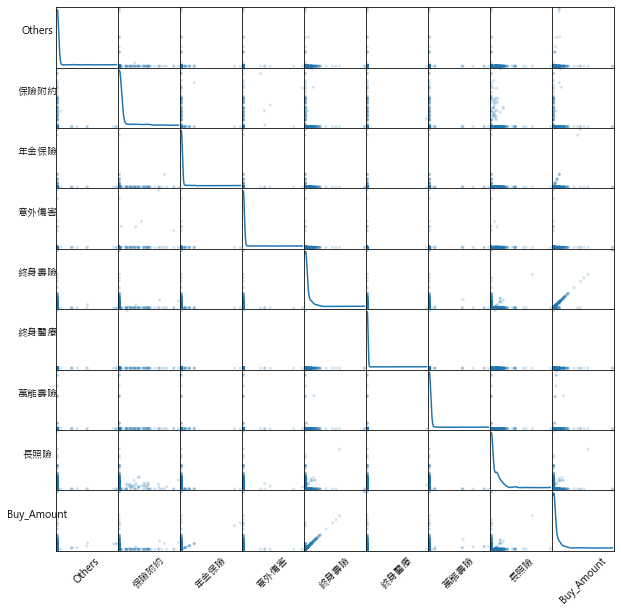

In [6]:
# Scatter_matrix plot of all features
Insurance_flat_numeric = Insurance_flat.iloc[:,:-2]
sm = pd.plotting.scatter_matrix(Insurance_flat_numeric, alpha=0.2, figsize=(10, 10), diagonal = 'kde')

# Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

# Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()
plt.savefig('Insurance_2019_Var.png')

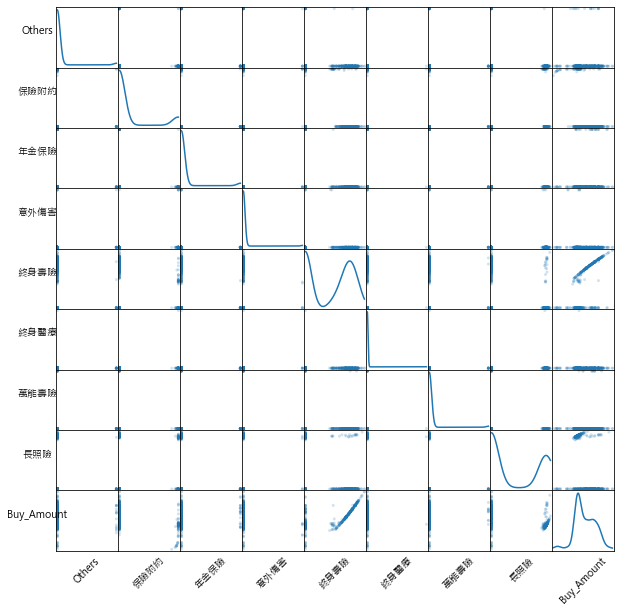

In [7]:
# Scale the data using the Box Cox method
from sklearn.preprocessing import PowerTransformer

bc = PowerTransformer(method='box-cox')
Insurance_scaled_features = bc.fit_transform(Insurance_flat_numeric.values)
Insurance_scaled_features_df = pd.DataFrame(Insurance_scaled_features, index=Insurance_flat_numeric.index,\
                                         columns=Insurance_flat_numeric.columns)
sm = pd.plotting.scatter_matrix(Insurance_scaled_features_df, alpha=0.2, figsize=(10, 10), diagonal = 'kde')

# Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

# Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

# plt.show()
plt.savefig('Insurance_2019_Var_Norm.png')

In [6]:
# Gender_df 
Gender_df = Insurance_flat.groupby('Gender').size().to_frame(name = 'Size')
Gender_df['Buy_Amount'] = Insurance_flat.groupby('Gender')['Buy_Amount'].sum()
Gender_df['Buy_Amount'] = Gender_df['Buy_Amount'].apply(lambda x: round(x, 0))
Gender_df

,Size,Buy_Amount
Gender,,
FEMALE,366,128960879
MALE,198,75632742


In [8]:
# Age df
Age_df = Insurance_flat.groupby('Age_bins').size().to_frame(name = 'Size')
Age_df['Buy_Amount'] = Insurance_flat.groupby('Age_bins')['Buy_Amount'].sum()
Age_df

,Size,Buy_Amount
Age_bins,,
0-19,58,14235424
20-39,158,36295097
40-49,150,36834466
50-59,122,51301377
60-69,67,59494620
70+,9,6432637


Text(0.5, 1.0, 'Insurance_2019_Age_distribution')

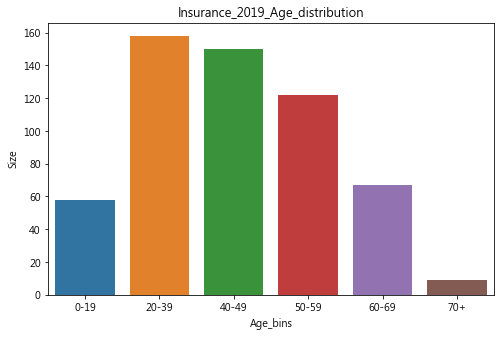

In [11]:
# Plot age distribution
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index,y = Age_df['Size'])
plt.title('Insurance_2019_Age_distribution')

Text(0.5, 1.0, 'Insurance_2019_Age_buy_amount')

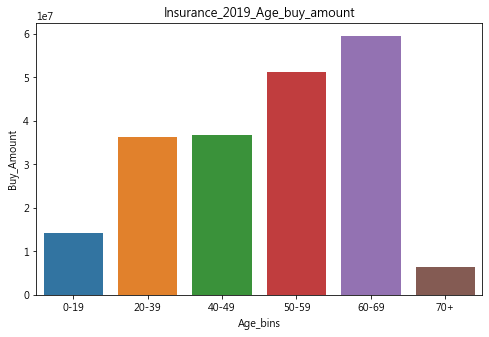

In [12]:
# Age_bin vs. Buy_amount barplot
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index, y = Age_df.Buy_Amount)
plt.title('Insurance_2019_Age_buy_amount')

Text(0.5, 1.0, 'Insurance_2019_Age_Average_buy_amount')

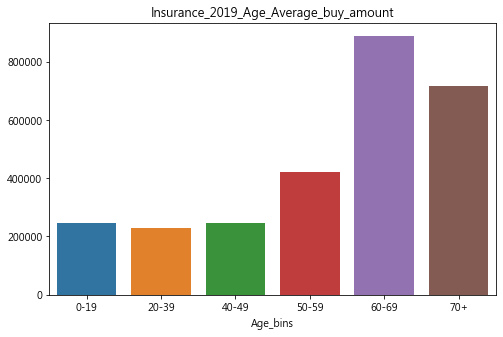

In [13]:
# Age_bin vs. Buy_amount barplot
plt.figure(figsize = (8,5))
sns.barplot(x = Age_df.index, y = Age_df.Buy_Amount / Age_df.Size)
plt.title('Insurance_2019_Age_Average_buy_amount')

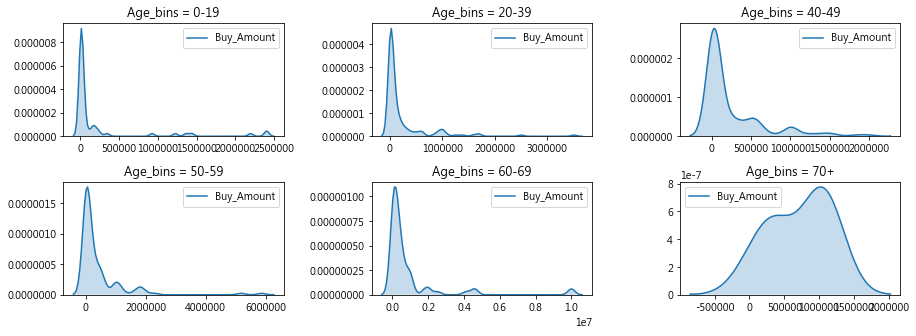

In [34]:
# Age bin kde plot
fig , ax = plt.subplots(figsize = (15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,j in enumerate(np.sort(Insurance_flat.Age_bins.unique())):
    plt.subplot(2, 3, i+1)
    filter_ = Insurance_flat['Age_bins'] == j
    sns.kdeplot(Insurance_flat.loc[filter_].Buy_Amount, shade=True)
    plt.title("Age_bins = {}" .format(j))

## Outlier Detection

In [15]:
# Outlier detection
import xlsxwriter

# Create a new df with the descriptive features
Insurance_feat_w_prop_df = Insurance_flat_numeric
# Insurance_feat_w_prop_df['Customer_Name'] = Insurance.groupby(['Customer_ID'])['Customer_Name'].first()
Insurance_feat_w_prop_df['Age'] = Insurance.groupby(['Customer_ID'])['Age'].first()
Insurance_feat_w_prop_df['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_feat_w_prop_df['Constellation'] = Insurance.groupby(['Customer_ID'])['Constellation'].first()
Insurance_feat_w_prop_df['Buy_Amount'] = Insurance.groupby(['Customer_ID'])['Buy_Amount'].sum()
Insurance_feat_w_prop_df['Com_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_feat_w_prop_df['Sales_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_feat_w_prop_df['Sales_Name'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()

feature_outliers = []
writer = pd.ExcelWriter('Insurance_2019_Outliers_sheets.xlsx', engine='xlsxwriter')

for feature in Insurance_scaled_features_df.keys():
    Q1 = np.percentile(Insurance_scaled_features_df[feature], 25)
    Q3 = np.percentile(Insurance_scaled_features_df[feature], 75)
    step = 1.5*(Q3 - Q1)
    Outlier_Index = ~((Insurance_scaled_features_df[feature] >= Q1 - step)&\
                       (Insurance_scaled_features_df[feature] <= Q3 + step))
    Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[Outlier_Index].index,:].groupby(['Customer_ID']).first()\
    .to_excel(writer, sheet_name = feature)
    feature_outliers.append(Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[Outlier_Index].index,:])
writer.save()

# Flatten list of outliers
outliers_flattened = []

for i, j in enumerate(feature_outliers):
    outliers_flattened.append(feature_outliers[i].index)
flat_list = [item for sublist in outliers_flattened for item in sublist]

# Count the number of features for which a given observation is considered an outlier
from collections import Counter
outlier_count = Counter(flat_list)
outliers = [observation for observation in outlier_count.elements() if outlier_count[observation] >= 3]
Insurance_feat_w_prop_df.loc[Insurance_scaled_features_df.loc[outliers].index,:].groupby(['Customer_ID']).first()\
.to_csv('Insurance_2019_Outliers.csv', encoding='utf_8_sig')

In [6]:
# Drop the outliers
Insurance_flat = Insurance_flat.drop(['A133583659'])

In [7]:
# Rescale data
Insurance_flat_numeric = Insurance_flat.iloc[:,:-2]
bc = PowerTransformer(method='box-cox')
Insurance_scaled_features = bc.fit_transform(Insurance_flat_numeric.values)
Insurance_scaled_features_df = pd.DataFrame(Insurance_scaled_features, index=Insurance_flat_numeric.index,\
                                         columns=Insurance_flat_numeric.columns)

## PCA vs. SVD

,Explained Var,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Dim 1,0.2481,-0.0169,0.2865,-0.0401,0.1094,-0.5459,0.0683,-0.0353,0.4675,-0.5457,-0.2896
Dim 2,0.1227,-0.1961,0.4941,-0.4421,0.4613,0.3859,0.1506,-0.1018,-0.2354,-0.0306,-0.2662
Dim 3,0.1103,0.3473,0.3272,0.6432,0.4126,-0.1618,0.1209,-0.0220,-0.3518,-0.0075,0.1526
Dim 4,0.1040,0.0885,-0.0274,-0.0831,0.1086,-0.0941,-0.2139,0.9094,-0.1607,0.0169,-0.2549
Dim 5,0.1033,0.8680,-0.0103,-0.4600,-0.0446,-0.0170,-0.0880,-0.1369,-0.0388,-0.0504,0.0462
Dim 6,0.1006,0.0824,0.0704,-0.0651,-0.3042,-0.0174,0.9080,0.2462,-0.0066,0.0644,0.0438
Dim 7,0.0860,-0.0782,-0.2315,-0.2386,0.5892,-0.1082,0.1288,0.1545,0.3130,0.0715,0.6171
Dim 8,0.0764,0.1282,-0.5711,0.1295,0.3877,0.0144,0.2315,-0.1614,0.1055,0.1982,-0.6000
Dim 9,0.0428,0.1159,0.4256,0.0860,-0.0292,0.0057,-0.0991,0.0420,0.5336,0.6998,-0.1051
Dim 10,0.0057,0.1915,-0.0030,0.2924,0.0154,0.7109,0.0057,0.1727,0.4256,-0.4002,0.0322


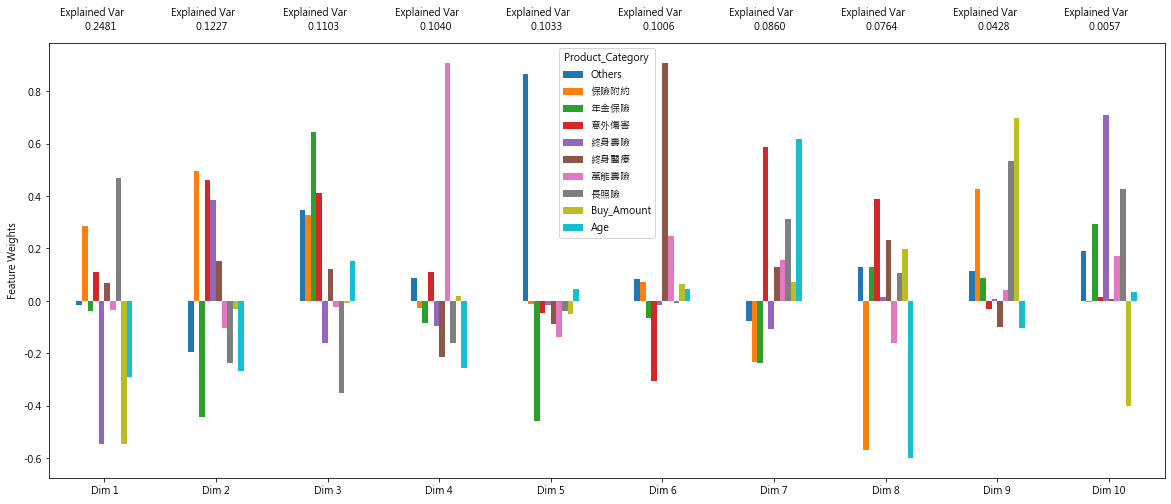

In [8]:
# PCA
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = Insurance_scaled_features_df.shape[1]
pca = PCA(n_components = num_features, random_state = 0)
pca = pca.fit(Insurance_scaled_features_df)

# Transform log_samples using the PCA fit above

# Generate PCA results plot
vs.pca_results(Insurance_scaled_features_df, pca)

,Explained Var,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Dim 1,0.2481,-0.0169,0.2865,-0.0401,0.1094,-0.5459,0.0683,-0.0353,0.4675,-0.5457,-0.2896
Dim 2,0.1227,-0.1961,0.4941,-0.4421,0.4613,0.3859,0.1506,-0.1018,-0.2354,-0.0306,-0.2662
Dim 3,0.1103,0.3473,0.3272,0.6432,0.4126,-0.1618,0.1209,-0.0220,-0.3518,-0.0075,0.1526
Dim 4,0.1040,0.0885,-0.0274,-0.0831,0.1086,-0.0941,-0.2139,0.9094,-0.1607,0.0169,-0.2549
Dim 5,0.1033,0.8680,-0.0103,-0.4600,-0.0446,-0.0170,-0.0880,-0.1369,-0.0388,-0.0504,0.0462
Dim 6,0.1006,0.0824,0.0704,-0.0651,-0.3042,-0.0174,0.9080,0.2462,-0.0066,0.0644,0.0438
Dim 7,0.0860,-0.0782,-0.2315,-0.2386,0.5892,-0.1082,0.1288,0.1545,0.3130,0.0715,0.6171
Dim 8,0.0764,0.1282,-0.5711,0.1295,0.3877,0.0144,0.2315,-0.1614,0.1055,0.1982,-0.6000
Dim 9,0.0428,0.1159,0.4256,0.0860,-0.0292,0.0057,-0.0991,0.0420,0.5336,0.6998,-0.1051


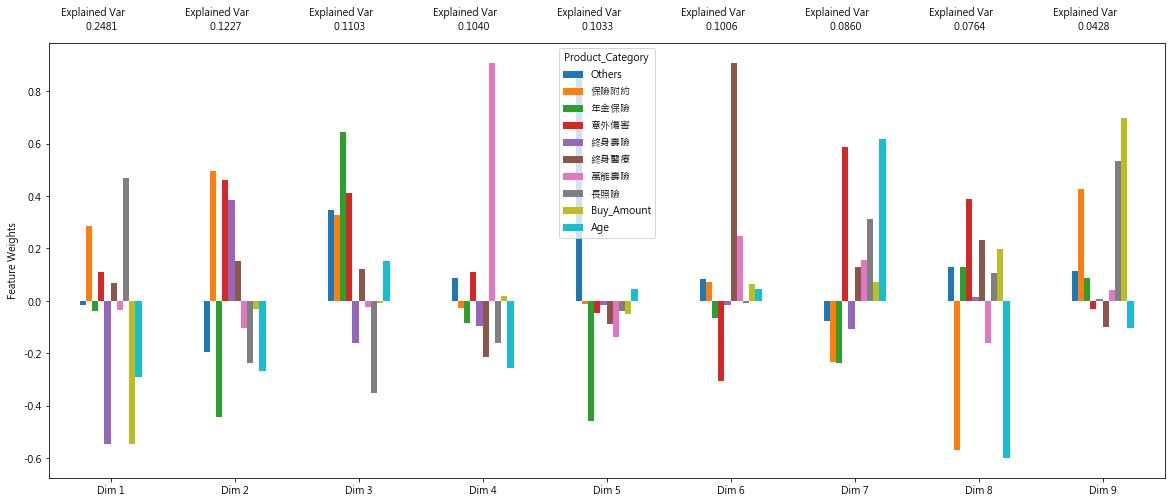

In [10]:
# SVD
from sklearn.decomposition import TruncatedSVD

# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = Insurance_scaled_features_df.shape[1] - 1
svd = TruncatedSVD(n_components = num_features, random_state = 0)
svd = svd.fit(Insurance_scaled_features_df)

# Transform log_samples using the PCA fit above

# Generate PCA results plot
vs.pca_results(Insurance_scaled_features_df, svd)

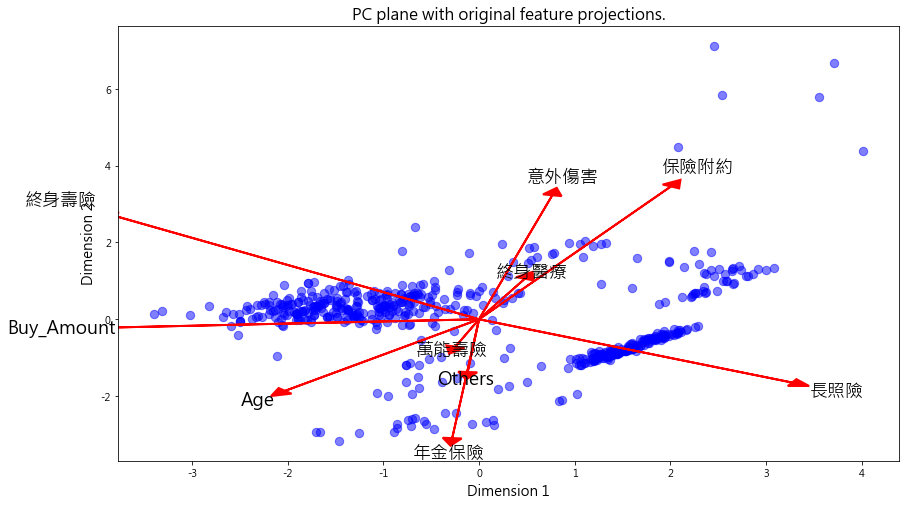

In [9]:
# Apply PCA by fitting data with only 2 Dimensions
pca = PCA(n_components = 2, random_state = 0)
pca = pca.fit(Insurance_scaled_features_df)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(Insurance_scaled_features_df)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

vs.biplot(Insurance_scaled_features_df ,reduced_data, pca)

## K means Clustering

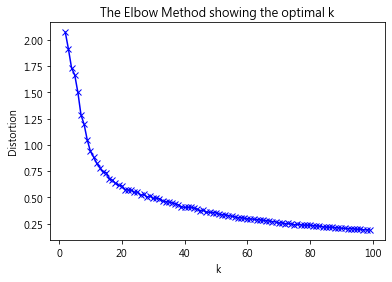

In [10]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(2,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Insurance_scaled_features_df)
    distortions.append(sum(np.min(cdist(Insurance_scaled_features_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / \
                       Insurance_scaled_features_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

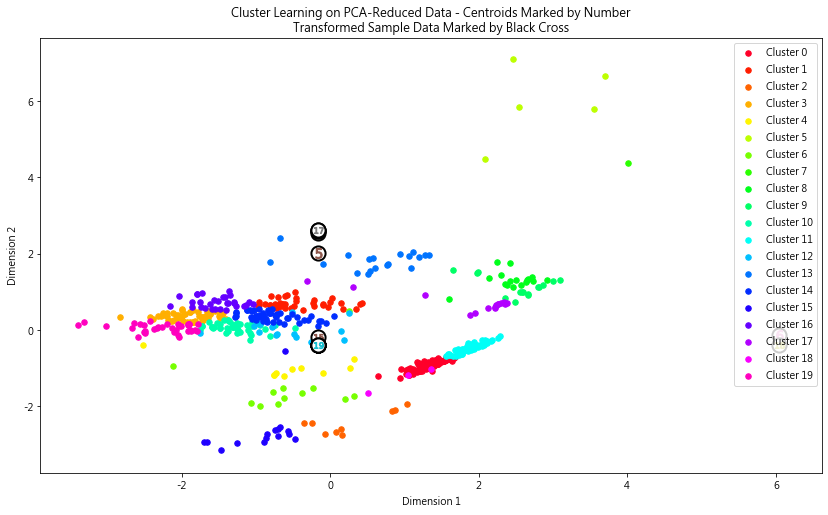

In [11]:
# Clustering(Elbow_method)
optimized_kmeans = KMeans(n_clusters = 20, random_state = 0).fit(Insurance_scaled_features_df)
kmeans_preds = optimized_kmeans.predict(Insurance_scaled_features_df)
kmeans_centers = optimized_kmeans.cluster_centers_
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers)

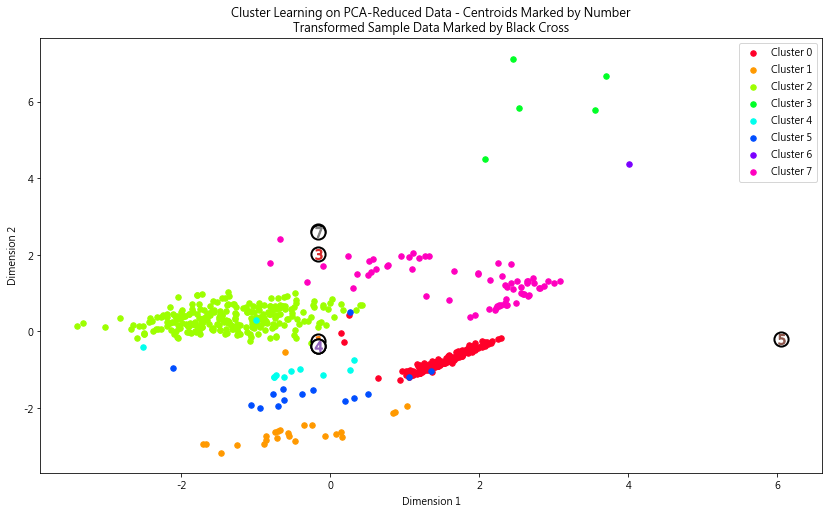

In [12]:
# Clustering(silhouette_score method)
# Clustering(silhouette_score method)
# silhouette_score method
num_clusters = np.arange(2,30)
kmeans_results = {}
for size in num_clusters:
    kmeans = KMeans(n_clusters = size).fit(Insurance_scaled_features_df)
    preds = kmeans.predict(Insurance_scaled_features_df)
    kmeans_results[size] = metrics.silhouette_score(Insurance_scaled_features_df, preds)
    
best_size = max(kmeans_results, key = kmeans_results.get)

optimized_kmeans = KMeans(n_clusters = best_size, random_state = 0).fit(Insurance_scaled_features_df)
kmeans_preds = optimized_kmeans.predict(Insurance_scaled_features_df)
kmeans_centers = optimized_kmeans.cluster_centers_
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers)

For n_clusters = 2 The average silhouette_score is : 0.35724819104185346
For n_clusters = 3 The average silhouette_score is : 0.40978858267591567
For n_clusters = 4 The average silhouette_score is : 0.43954693139870427
For n_clusters = 5 The average silhouette_score is : 0.4698366194210562
For n_clusters = 6 The average silhouette_score is : 0.48653602819242414
For n_clusters = 7 The average silhouette_score is : 0.4909636662704907
For n_clusters = 8 The average silhouette_score is : 0.548448531945918
For n_clusters = 9 The average silhouette_score is : 0.47350340867205
For n_clusters = 10 The average silhouette_score is : 0.45179785789909277
For n_clusters = 11 The average silhouette_score is : 0.45965798733631846
For n_clusters = 12 The average silhouette_score is : 0.4375280888797634
For n_clusters = 13 The average silhouette_score is : 0.45894613646712973
For n_clusters = 14 The average silhouette_score is : 0.47405593735900203
For n_clusters = 15 The average silhouette_score is : 

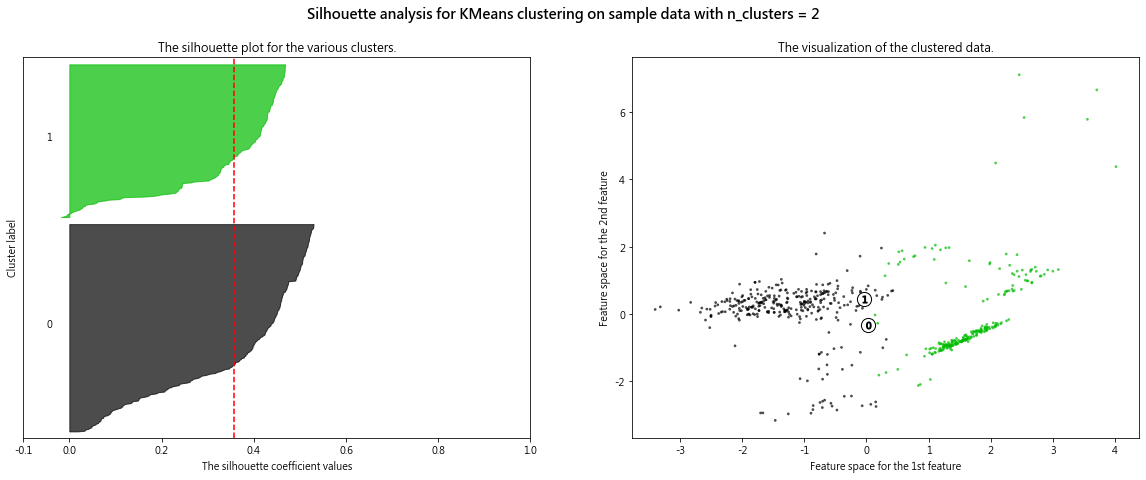

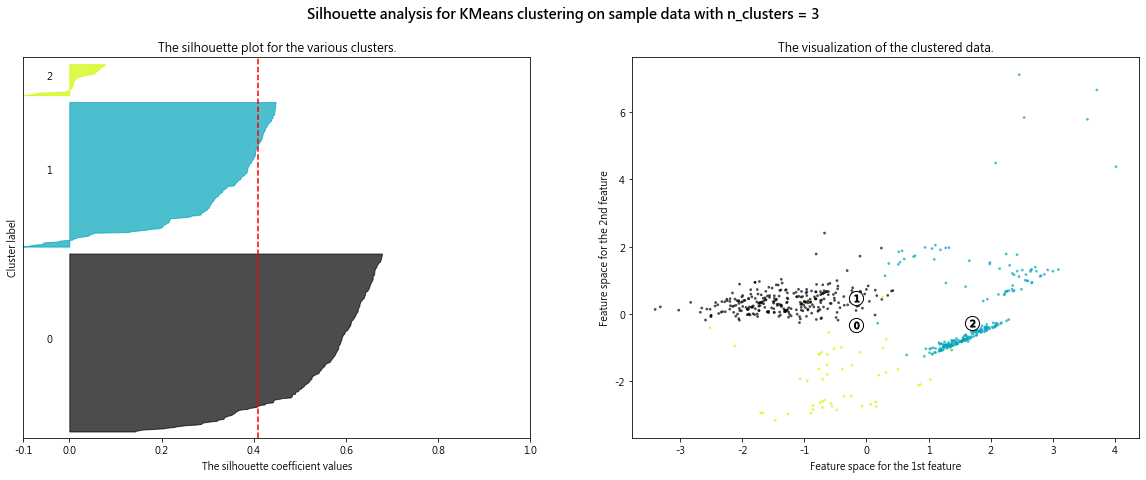

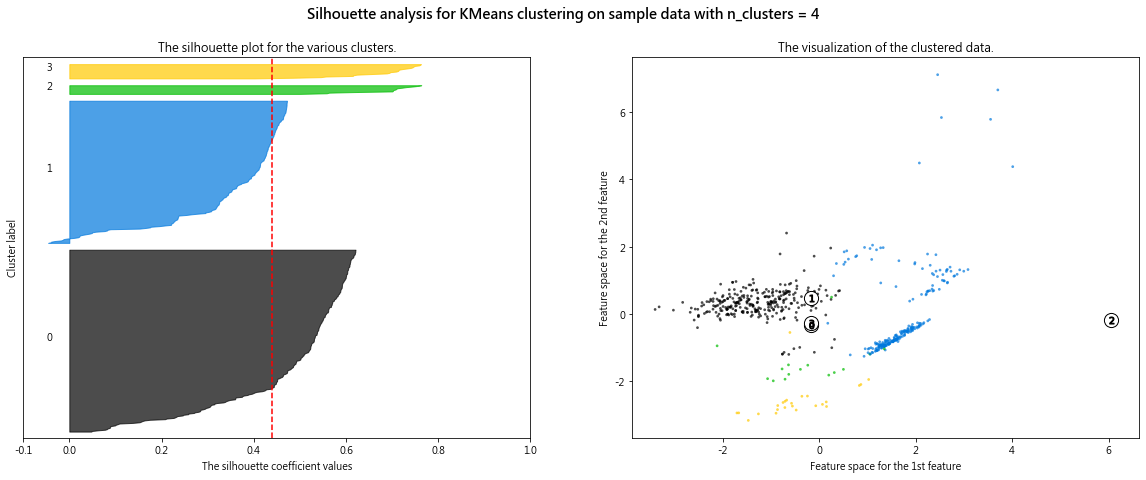

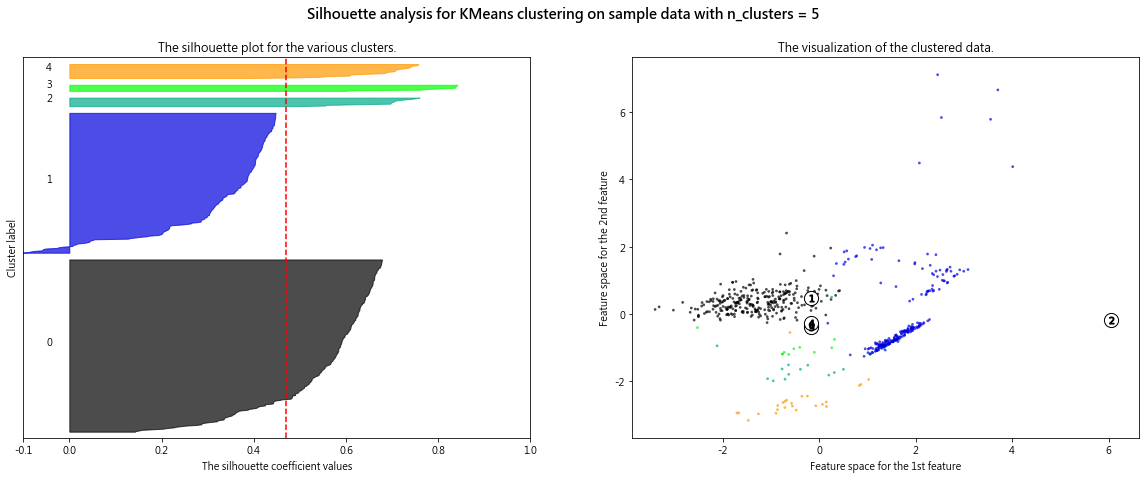

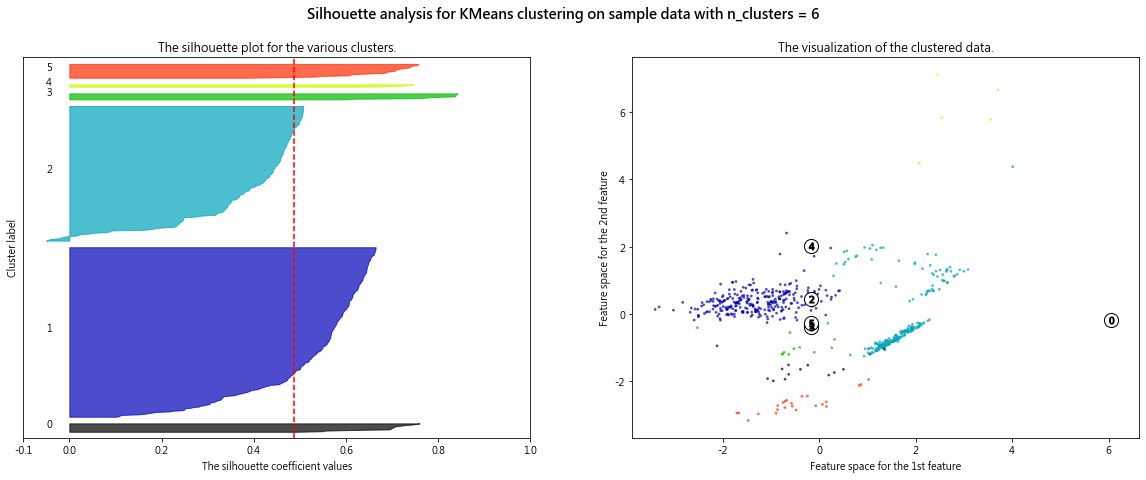

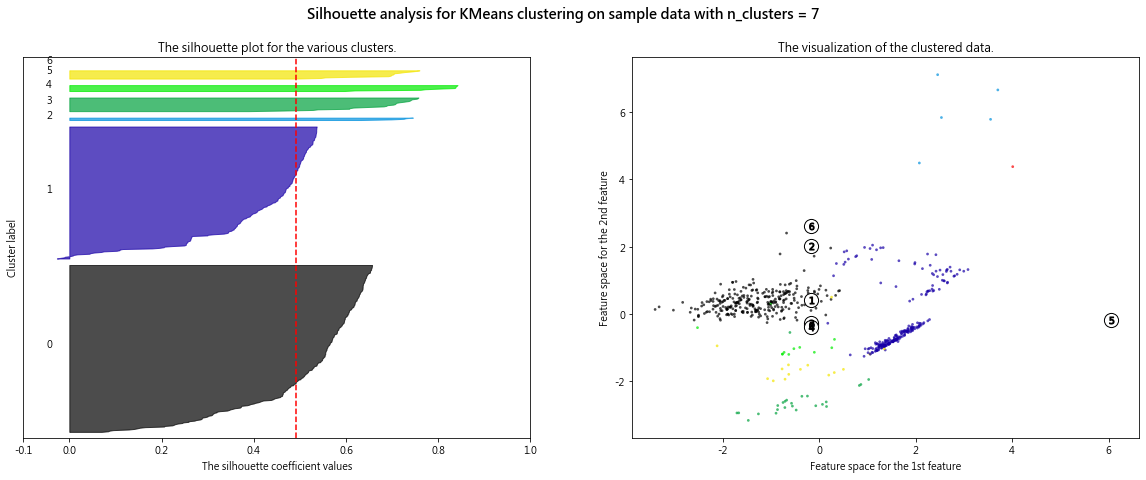

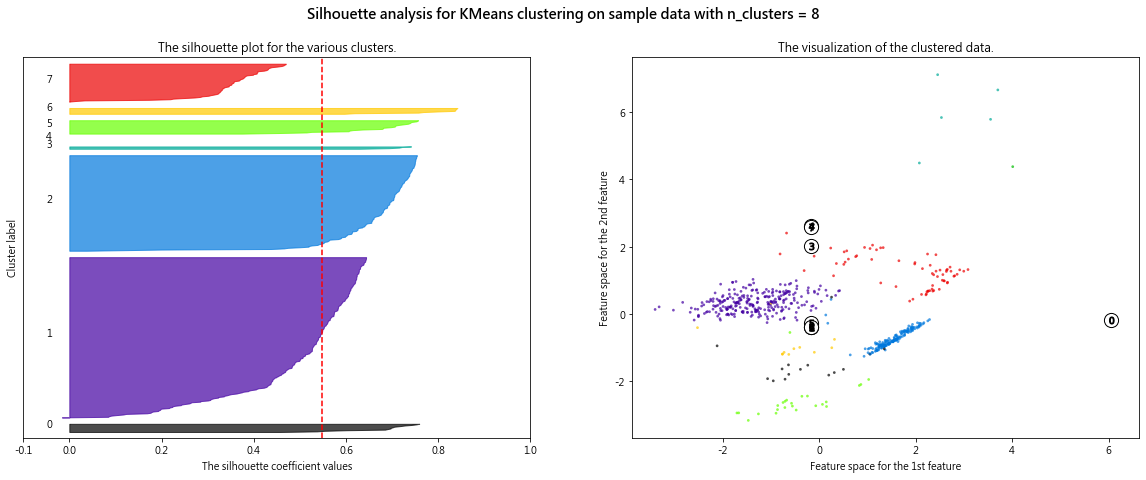

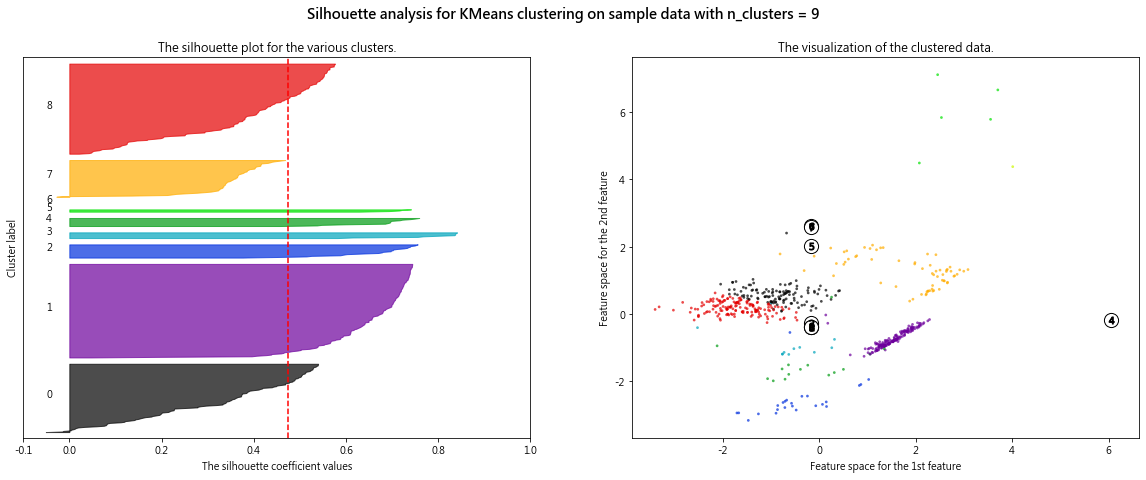

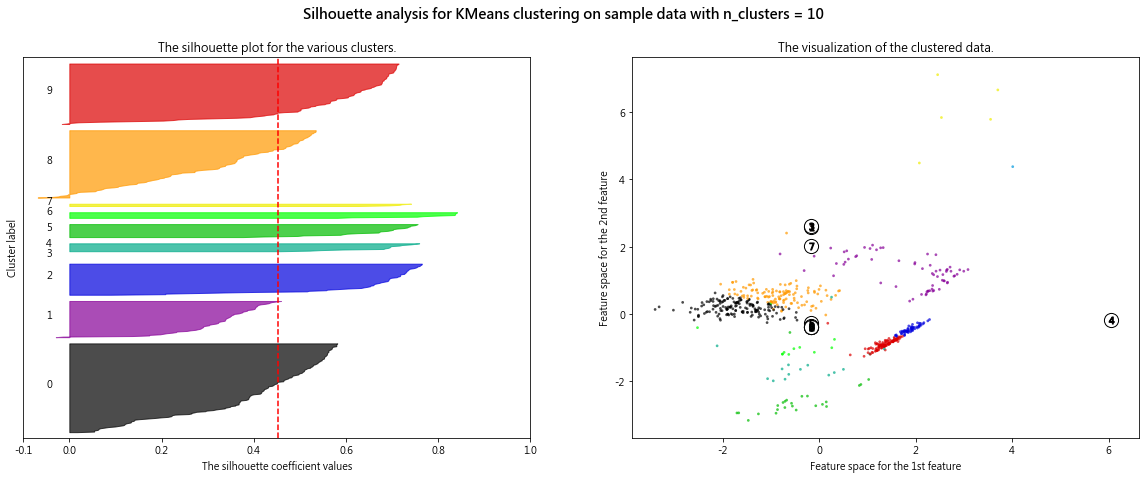

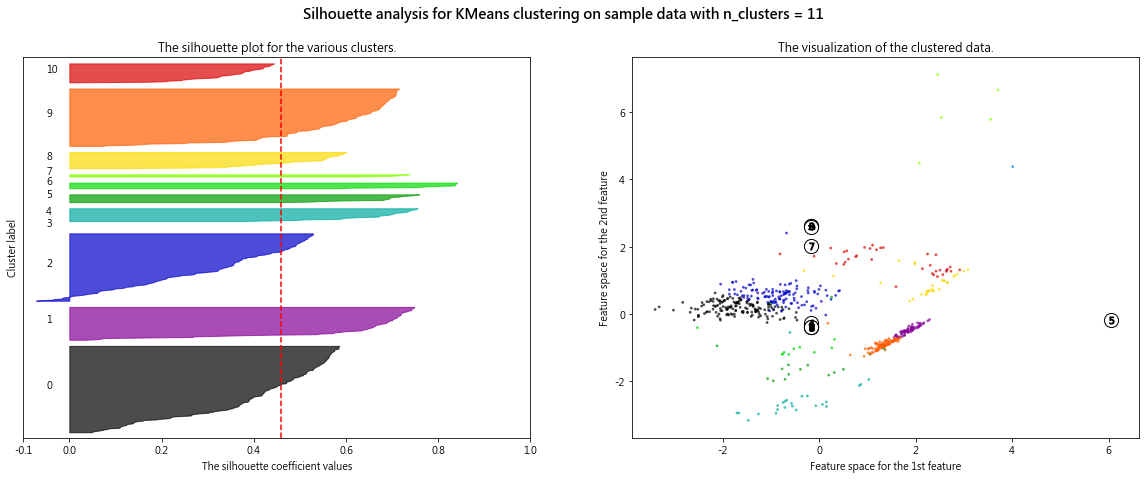

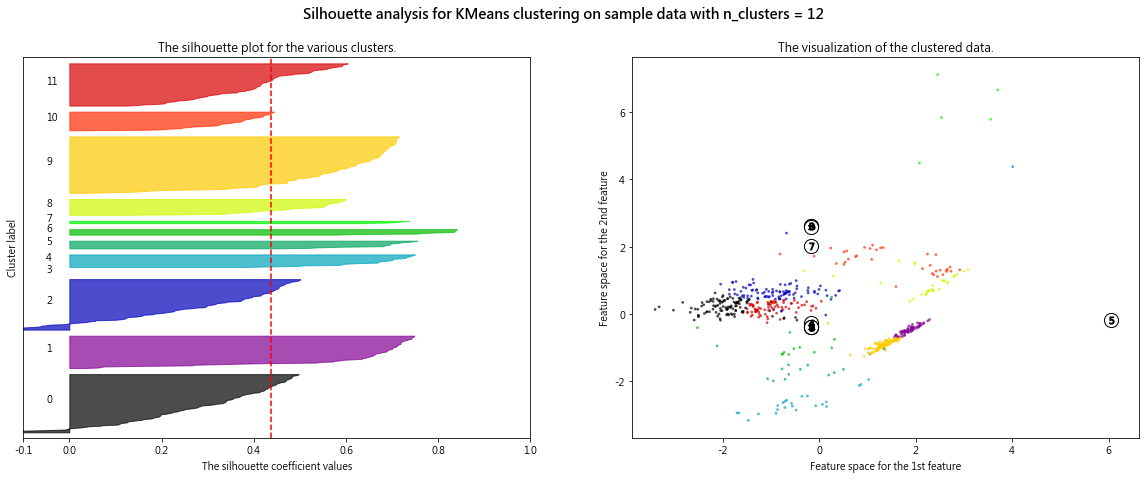

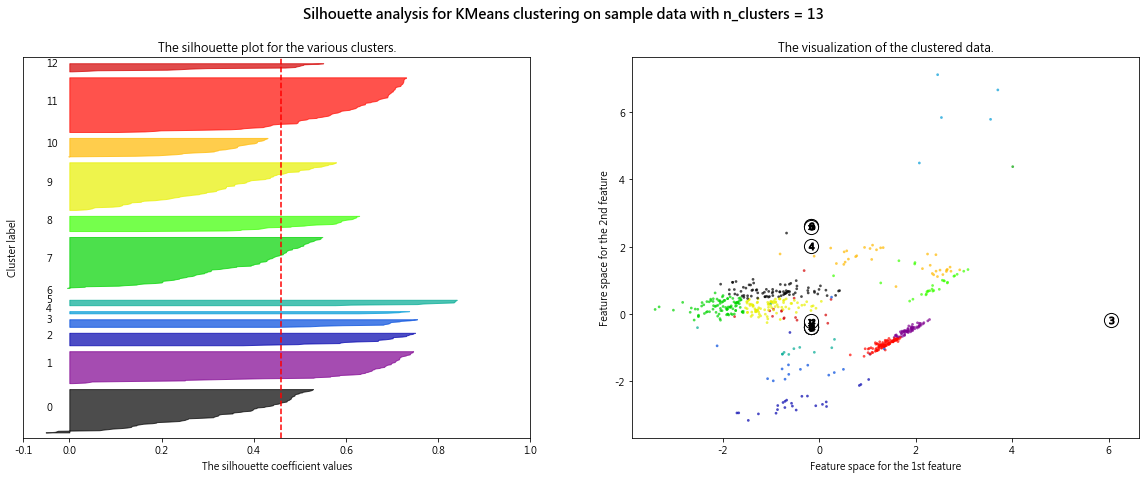

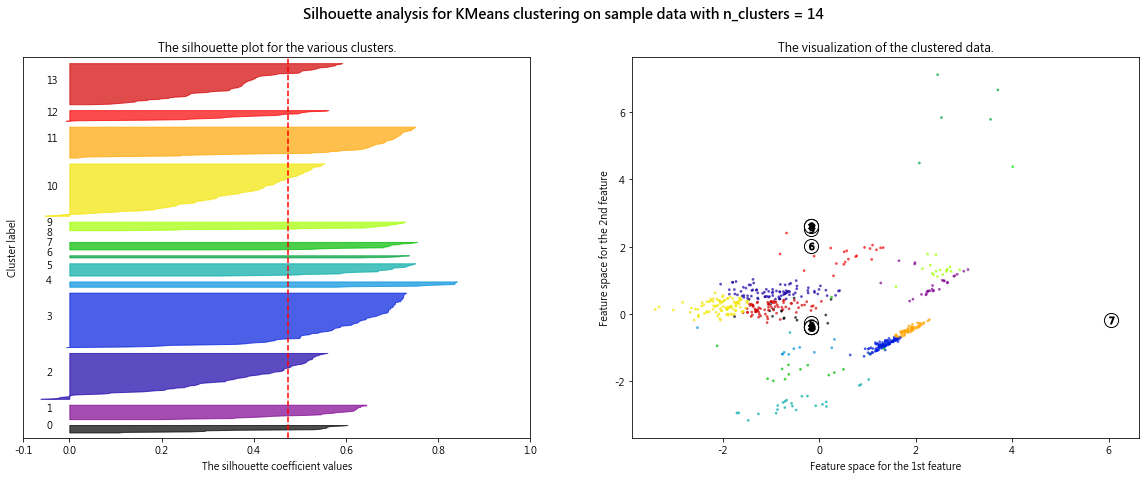

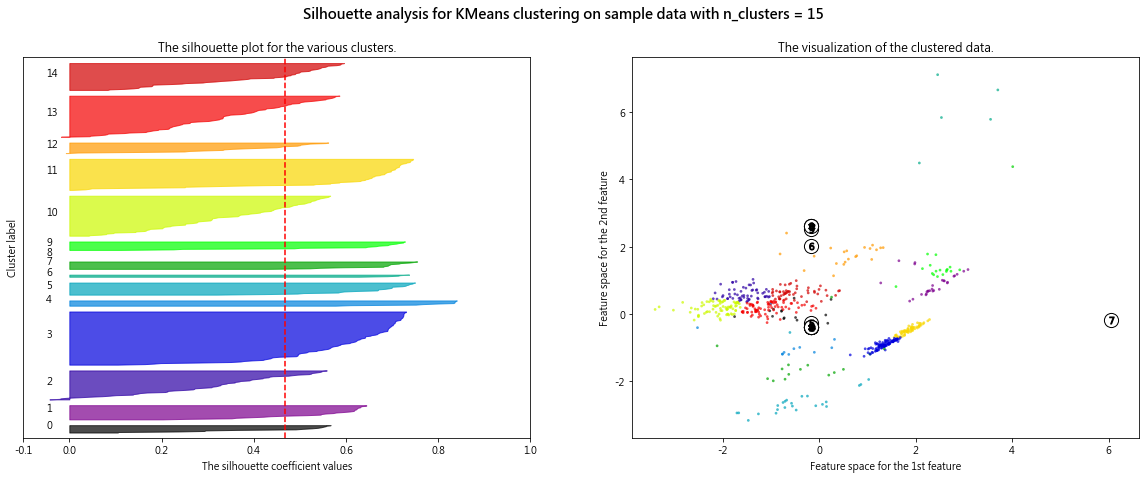

In [13]:
# silhouette_score plot
vs.Silhouette_score(r = 16, df = Insurance_scaled_features_df, reduced_df = reduced_data)
plt.savefig('Insurance_2019'+ '_Silhouette_score' + '.png')

## K Prototype Clustering

In [14]:
Insurance_scaledfeat_w_prop_df = Insurance_scaled_features_df
Insurance_scaledfeat_w_prop_df['Age_bins'] = Insurance_flat['Age_bins']
Insurance_scaledfeat_w_prop_df['Gender'] = Insurance.groupby(['Customer_ID'])['Gender'].first()
Insurance_scaledfeat_w_prop_df['Constellation'] = Insurance.groupby(['Customer_ID'])['Constellation'].first()
Insurance_scaledfeat_w_prop_df['Com_ID'] = Insurance.groupby(['Customer_ID'])['Com_ID'].first()
Insurance_scaledfeat_w_prop_df['Sales_ID'] = Insurance.groupby(['Customer_ID'])['Sales_ID'].first()
Insurance_scaledfeat_w_prop_df.head()

Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age,Age_bins,Gender,Constellation,Com_ID,Sales_ID
Customer_ID,,,,,,,,,,,,,,,
A120675488,-0.165446,-0.385912,4.739022,-0.09466,-1.080124,-0.042182,-0.141165,-0.77092,1.084875,0.270907,40-49,MALE,金牛座,585J,03138
A120778788,-0.165446,-0.385912,-0.211014,-0.09466,-1.080124,-0.042182,-0.141165,1.35530,-0.459685,0.404703,40-49,MALE,白羊座,585Z,92139
A120844152,-0.165446,2.610186,-0.211014,-0.09466,0.226832,-0.042182,-0.141165,-0.77092,-0.698886,0.138288,40-49,MALE,白羊座,5854,08005
A121706428,-0.165446,2.515977,-0.211014,-0.09466,-1.080124,-0.042182,-0.141165,-0.77092,-2.895151,0.270907,40-49,MALE,摩羯座,585b,87123
A122767372,-0.165446,-0.385912,-0.211014,-0.09466,-1.080124,-0.042182,-0.141165,1.39906,-0.186821,0.138288,40-49,MALE,雙魚座,585Z,93337


In [17]:
from kmodes.kprototypes import KPrototypes

# K Prototype Clustering
kproto = KPrototypes(n_clusters = best_size, init='Cao', verbose=2)
kproto_preds = kproto.fit_predict(Insurance_scaledfeat_w_prop_df, categorical=[10, 11, 12, 13, 14])
kproto_centers = kproto.cluster_centroids_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 155, ncost: 2874.659036638879
Run: 1, iteration: 2/100, moves: 32, ncost: 2863.998751132715
Run: 1, iteration: 3/100, moves: 9, ncost: 2862.9636537193755
Run: 1, iteration: 4/100, moves: 11, ncost: 2858.7604024924995
Run: 1, iteration: 5/100, moves: 0, ncost: 2858.7604024924995
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 222, ncost: 2888.3549803663573
Run: 2, iteration: 2/100, moves: 112, ncost: 2365.7414358845713
Run: 2, iteration: 3/100, moves: 4, ncost: 2361.158566624081
Run: 2, iteration: 4/100, moves: 0, ncost: 2361.158566624081
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 82, ncost: 3036.630014092583
Run: 3, iteration: 2/100, moves: 32, ncost: 3012.184096518982
Run: 3, iteration: 3/100, moves: 26, ncost: 2992.827655216946
Run: 3, iter

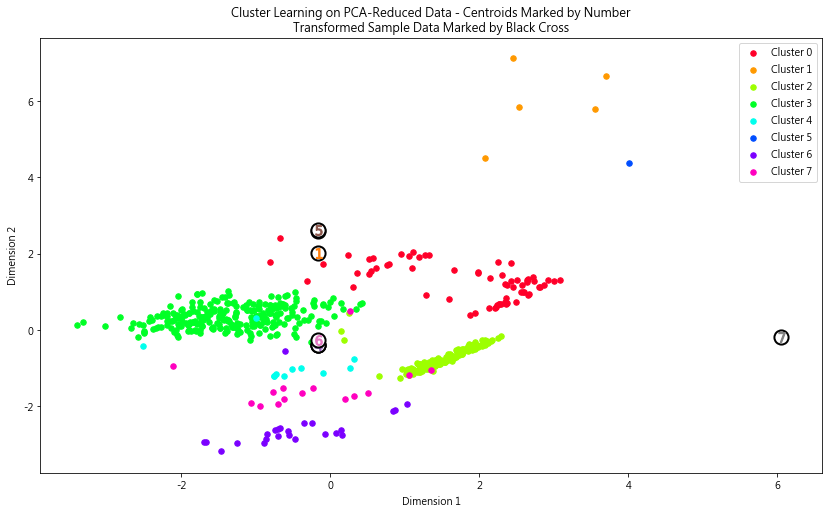

In [19]:
# Plot k prototype
vs.cluster_results(reduced_data, kproto_preds, kproto_centers[0])

## Data Recovery

In [29]:
## K means
# Inverse transform the box-cox centers
true_centers = bc.inverse_transform(kmeans_centers)
true_centers[np.isnan(true_centers)] = 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(kmeans_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = Insurance_scaled_features_df.iloc[:,:9].keys())
true_centers.index = segments
display(true_centers)

# Segment mean
Insurance_flat['Label'] = optimized_kmeans.labels_
display(round(Insurance_flat.groupby('Label').mean()))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2909: RuntimeWarning: divide by zero encountered in power
  x_inv = (x * lmbda + 1) ** (1 / lmbda)


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount
Segment 0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15726.0,16531.0
Segment 1,1.0,1.0,1.0,1.0,246003.0,1.0,1.0,1.0,260704.0
Segment 2,1.0,170.0,1.0,1.0,34.0,1.0,1.0,15.0,6728.0
Segment 3,1.0,1.0,23309.0,1.0,1.0,1.0,1.0,1.0,212899.0
Segment 4,1.0,1.0,1.0,1.0,14.0,1.0,5624.0,1.0,251865.0
Segment 5,5285.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,117062.0
Segment 6,1.0,3358.0,1.0,1.0,1.0,inf,1.0,8910.0,20284.0
Segment 7,1.0,7.0,1.0,13.0,14.0,1.0,1.0,19.0,8789.0


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Label,,,,,,,,,,
0,1.0,1.0,1.0,1.0,725.0,1.0,1.0,19016.0,19740.0,40.0
1,1.0,62.0,1.0,1.0,616300.0,1.0,1.0,1063.0,617423.0,46.0
2,1.0,6887.0,1.0,1.0,30786.0,1.0,1.0,4555.0,42226.0,37.0
3,1.0,791.0,683844.0,1.0,138.0,1.0,1.0,1.0,684771.0,50.0
4,1.0,1.0,1.0,1.0,156835.0,1.0,274254.0,1.0,431088.0,40.0
5,341796.0,440.0,1.0,1.0,36602.0,1.0,1.0,1.0,378836.0,48.0
6,1.0,3358.0,1.0,1.0,1.0,8016.0,1.0,8910.0,20284.0,37.0
7,21.0,9384.0,1.0,839.0,632.0,1.0,1.0,3916.0,14788.0,26.0


In [21]:
## K mode
# Inverse transform the box-cox centers
true_centers = bc.inverse_transform(kproto_centers[0])
true_centers[np.isnan(true_centers)] = 1
df1 = pd.DataFrame(kproto_centers[1], columns = Insurance_scaledfeat_w_prop_df.iloc[:,[10, 11, 12, 13, 14]].keys())
df2 = pd.DataFrame(np.round(true_centers), columns = Insurance_scaled_features_df.iloc[:,:10].keys())

# Display the true centers
kmeans_centers = 8
segments = ['Segment {}'.format(i) for i in range(0,kmeans_centers)]
true_centers_true = df1.merge(df2, left_index = True, right_index = True)
true_centers_true.index = segments
display(true_centers_true)

# Segment mean
Insurance_flat['Label'] = kproto.labels_
display(round(Insurance_flat.groupby('Label').mean()))

C:\Users\User\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2909: RuntimeWarning: divide by zero encountered in power
  x_inv = (x * lmbda + 1) ** (1 / lmbda)


Product_Category,Age_bins,Gender,Constellation,Com_ID,Sales_ID,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Segment 0,20-39,FEMALE,水瓶座,5850,87307,1.0,168.0,1.0,1.0,41.0,1.0,1.0,14.0,7421.0,37.0
Segment 1,0-19,FEMALE,天蠍座,585V,92255,1.0,5.0,1.0,inf,23.0,1.0,1.0,9.0,7661.0,33.0
Segment 2,40-49,FEMALE,獅子座,5853,04205,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15664.0,16815.0,40.0
Segment 3,20-39,FEMALE,獅子座,5855,82222,1.0,1.0,1.0,1.0,244810.0,1.0,1.0,1.0,259347.0,47.0
Segment 4,40-49,FEMALE,巨蟹座,5857,88114,1.0,1.0,1.0,1.0,14.0,1.0,inf,1.0,251946.0,41.0
Segment 5,20-39,FEMALE,白羊座,585Z,97163,1.0,3358.0,1.0,1.0,1.0,inf,1.0,8910.0,20284.0,37.0
Segment 6,50-59,FEMALE,金牛座,5854,03138,1.0,1.0,23339.0,1.0,1.0,1.0,1.0,1.0,213051.0,50.0
Segment 7,50-59,FEMALE,水瓶座,585I,90163,5199.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,117171.0,49.0


Product_Category,Others,保險附約,年金保險,意外傷害,終身壽險,終身醫療,萬能壽險,長照險,Buy_Amount,Age
Label,,,,,,,,,,
0,1.0,7040.0,1.0,1.0,50757.0,1.0,1.0,4486.0,62281.0,36.0
1,1.0,9391.0,1.0,869.0,758.0,1.0,1.0,3293.0,14310.0,31.0
2,1.0,1.0,1.0,1.0,1973.0,1.0,1.0,18954.0,20926.0,40.0
3,1.0,1.0,1.0,1.0,615129.0,1.0,1.0,1039.0,616168.0,46.0
4,1.0,1.0,1.0,1.0,156835.0,1.0,274254.0,1.0,431088.0,40.0
5,1.0,3358.0,1.0,1.0,1.0,8016.0,1.0,8910.0,20284.0,37.0
6,1.0,791.0,683844.0,1.0,138.0,1.0,1.0,1.0,684771.0,50.0
7,341796.0,440.0,1.0,1.0,36602.0,1.0,1.0,1.0,378836.0,48.0


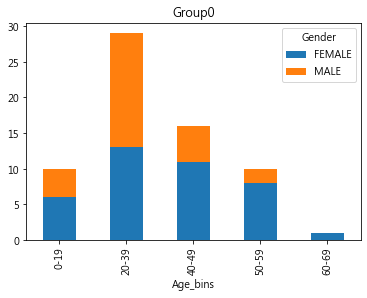

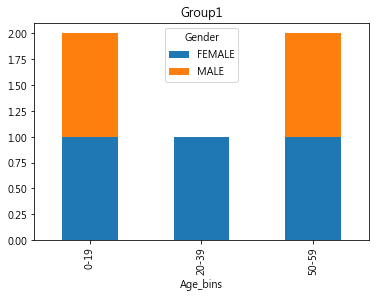

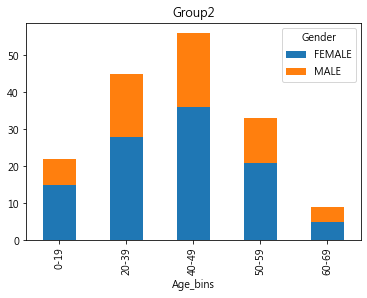

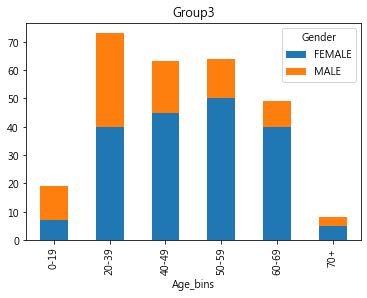

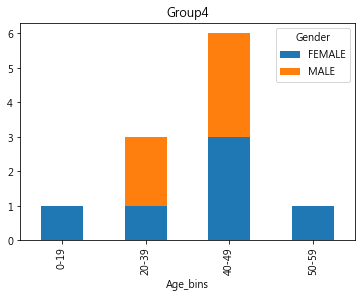

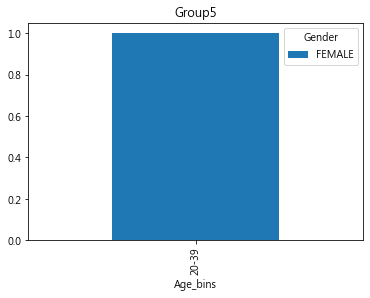

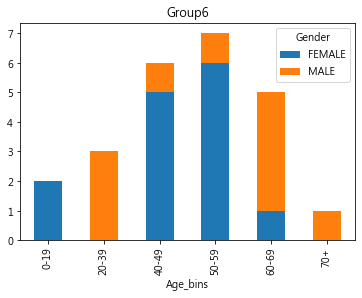

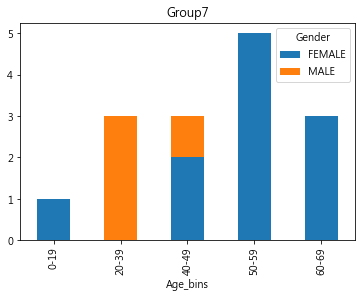

In [22]:
# Plot the Age_Sex features
for tag in np.sort(Insurance_flat['Label'].unique()):
    filter_ = Insurance_flat['Label'] == tag
    ct = pd.crosstab(Insurance_flat[filter_].Age_bins, Insurance_flat[filter_].Gender, margins = False)
    ct.plot.bar(stacked=True)
    plt.title('Group{}'.format(tag))

In [23]:
# Plot the Com_ID_df features
Insurance_scaledfeat_w_prop_df['Label'] = kproto.labels_
for tag in np.sort(Insurance_scaledfeat_w_prop_df['Label'].unique()):
    filter_ = Insurance_scaledfeat_w_prop_df['Label'] == tag
    Com_ID_df = Insurance_scaledfeat_w_prop_df[filter_].groupby('Com_ID').size().to_frame(name = 'Size')
    print('Gp_{}'.format(tag))
    display(Com_ID_df.sort_values(by = 'Size',ascending = False)[:3])

Gp_0


,Size
Com_ID,
5850,19
585b,6
585W,4


Gp_1


,Size
Com_ID,
585I,1
585P,1
585V,1


Gp_2


,Size
Com_ID,
5853,29
585Z,13
585b,10


Gp_3


,Size
Com_ID,
5855,21
5850,18
585D,17


Gp_4


,Size
Com_ID,
5857,5
585Y,2
585m,2


Gp_5


,Size
Com_ID,
585Z,1


Gp_6


,Size
Com_ID,
5854,5
5852,3
585H,3


Gp_7


,Size
Com_ID,
585I,4
5854,3
5857,2


In [25]:
# Save Customer list (k mode)
Insurance_flat.loc[:,['Age', 'Gender', 'Label']].to_excel('Insurance_2019_Customer_list.xlsx')

## ANOVA test (k means only)

In [32]:
# ANOVA test (k means)
import scipy.stats as ss
Insurance_flat_t = Insurance_flat.drop(['Gender','Age_bins'], axis = 1)
for Variable in Insurance_flat_t.keys():
    samples = [val[1] for val in Insurance_flat_t.groupby('Label')[Variable]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Variable: {}, F value: {:.3f}, p value: {:.3f}'.format(Variable, f_val, p_val))

Variable: Others, F value: 68.825, p value: 0.000
Variable: 保險附約, F value: 73.157, p value: 0.000
Variable: 年金保險, F value: 26.809, p value: 0.000
Variable: 意外傷害, F value: 328.637, p value: 0.000
Variable: 終身壽險, F value: 11.880, p value: 0.000
Variable: 終身醫療, F value: inf, p value: 0.000
Variable: 萬能壽險, F value: 158.836, p value: 0.000
Variable: 長照險, F value: 58.264, p value: 0.000
Variable: Buy_Amount, F value: 9.965, p value: 0.000
Variable: Age, F value: 6.215, p value: 0.000
Variable: Label, F value: 445714040408510848.000, p value: 0.000


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:3349: RuntimeWarning: divide by zero encountered in double_scalars
  f = msb / msw


In [26]:
# ANOVA test (k mode)
import scipy.stats as ss
Insurance_flat_t = Insurance_flat.drop(['Gender','Age_bins'], axis = 1)
for Variable in Insurance_flat_t.keys():
    samples = [val[1] for val in Insurance_flat_t.groupby('Label')[Variable]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Variable: {}, F value: {:.3f}, p value: {:.3f}'.format(Variable, f_val, p_val))

Variable: Others, F value: 68.698, p value: 0.000
Variable: 保險附約, F value: 80.214, p value: 0.000
Variable: 年金保險, F value: 26.759, p value: 0.000
Variable: 意外傷害, F value: 302.409, p value: 0.000
Variable: 終身壽險, F value: 11.564, p value: 0.000
Variable: 終身醫療, F value: -341200614352579520.000, p value: nan
Variable: 萬能壽險, F value: 158.545, p value: 0.000
Variable: 長照險, F value: 58.634, p value: 0.000
Variable: Buy_Amount, F value: 9.680, p value: 0.000
Variable: Age, F value: 6.337, p value: 0.000
Variable: Label, F value: 134560258496802448.000, p value: 0.000


In [27]:
# Chi-square for categorical var (k mode)
Insurance_scaledfeat_w_prop_df_chi = Insurance_scaledfeat_w_prop_df.iloc[:,-5:]
Insurance_scaledfeat_w_prop_df_chi['Label'] = kproto.labels_

for Variable in Insurance_scaledfeat_w_prop_df_chi.keys():
    samples = pd.crosstab(index = Insurance_scaledfeat_w_prop_df_chi['Label'], \
                          columns = Insurance_scaledfeat_w_prop_df_chi[Variable])
    chisq, p_val, df, ex = ss.chi2_contingency(samples, correction = False)
    print('Variable: {}, chi value: {:.3f}, p value: {:.3f}'.format(Variable, chisq, p_val))

Variable: Gender, chi value: 4.117, p value: 0.766
Variable: Constellation, chi value: 68.722, p value: 0.738
Variable: Com_ID, chi value: 527.643, p value: 0.000
Variable: Sales_ID, chi value: 2500.093, p value: 0.000
Variable: Label, chi value: 3941.000, p value: 0.000


In [28]:
# Turkey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

writer = pd.ExcelWriter('Insurance_2019_Turkey_HSD_sheets.xlsx', engine='xlsxwriter')
for Variable in Insurance_flat_t.keys():
    Results = pairwise_tukeyhsd(Insurance_flat_t[Variable], Insurance_flat_t['Label'])
    pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])\
    .to_excel(writer, sheet_name = Variable)
writer.save()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1291: RuntimeWarning: divide by zero encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic
C:\Users\User\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1291: RuntimeWarning: invalid value encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic



NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


C:\Users\User\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1299: RuntimeWarning: invalid value encountered in greater
  reject = st_range > q_crit
